In [2]:
%load_ext tensorboard
import datetime
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import numpy as np
import dataset

import gpu_utils
tf.get_logger().setLevel('INFO')
try:
    gpu_utils.setup_gpus()
except ValueError as ex:
    print(ex)

BUFFER_SIZE = 10000
BATCH_SIZE = 64  # 512


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Cannot set memory growth on device when virtual devices configured


In [3]:
data = dataset.load_file(BATCH_SIZE, 0.1, filenames=['bible_text/bible.txt', 'short_table/short_table.txt'])

In [8]:
EMBED_DIM = 64

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(data.letters_size, EMBED_DIM,  input_length=data.maxlen,
                              batch_size=BATCH_SIZE,
                              mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(EMBED_DIM*4, return_sequences=True), merge_mode='sum'),
    tf.keras.layers.Dense(EMBED_DIM*4, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(data.niqqud_size),
])
# best: mean_squared_logarithmic_error, stateless

model.compile(loss='mean_squared_logarithmic_error',
              optimizer='adam',
              metrics=['accuracy'])

plot_model(model, to_file='model.png')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (64, 400, 64)             3456      
_________________________________________________________________
bidirectional_1 (Bidirection (64, 400, 256)            494592    
_________________________________________________________________
dense_2 (Dense)              (64, 400, 256)            65792     
_________________________________________________________________
dropout_1 (Dropout)          (64, 400, 256)            0         
_________________________________________________________________
dense_3 (Dense)              (64, 400, 15)             3855      
Total params: 567,695
Trainable params: 567,695
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.load_weights(tf.train.latest_checkpoint('niqqud_checkpoints/'))

In [14]:
%tensorboard --logdir logs\fit

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 9972.

In [9]:
EPOCHS = 15

log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
while True:
    try:
        history = model.fit(data.input_texts, data.niqqud_texts,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          validation_data=(data.input_validation, data.niqqud_validation),
                          verbose=1,
                          callbacks=[
                              # tf.keras.callbacks.ModelCheckpoint(filepath='niqqud_checkpoints/ckpt_{epoch}', save_weights_only=True),
                              # tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3, verbose=1),
                              tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=0, min_lr=0.001),
                              # tensorboard_callback,
                          ]
                )
    except RuntimeError as ex:
        import sys
        print(ex, file=sys.strerr)
        model.load_weights(tf.train.latest_checkpoint('niqqud_checkpoints/'))
    else:
        break

Train on 27302 samples, validate on 3034 samples
Epoch 1/15
27302/27302 [==============================] - 32s 1ms/sample - loss: 0.0022 - accuracy: 0.7127 - val_loss: 0.0017 - val_accuracy: 0.8004
Epoch 2/15
27302/27302 [==============================] - 24s 896us/sample - loss: 0.0015 - accuracy: 0.8171 - val_loss: 0.0013 - val_accuracy: 0.8461
Epoch 3/15
27302/27302 [==============================] - 25s 898us/sample - loss: 0.0013 - accuracy: 0.8497 - val_loss: 0.0011 - val_accuracy: 0.8698
Epoch 4/15
27302/27302 [==============================] - 25s 906us/sample - loss: 0.0012 - accuracy: 0.8691 - val_loss: 0.0010 - val_accuracy: 0.8831
Epoch 5/15
27302/27302 [==============================] - 25s 905us/sample - loss: 0.0010 - accuracy: 0.8828 - val_loss: 9.2707e-04 - val_accuracy: 0.8948
Epoch 6/15
27302/27302 [==============================] - 25s 905us/sample - loss: 9.6631e-04 - accuracy: 0.8927 - val_loss: 8.6299e-04 - val_accuracy: 0.9017
Epoch 7/15
27302/27302 [===========

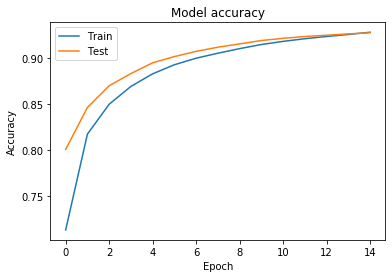

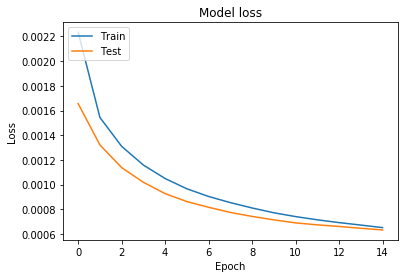

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.add(tf.keras.layers.Softmax())

def print_predictions(batch):
    results = data.merge(batch, model.predict(batch))

    for r in results:
        print(r)


model.add(tf.keras.layers.Softmax())

print_predictions(data.input_texts[0:BATCH_SIZE])

In [8]:
del model

In [29]:
print(history.history)

{'loss': [0.0015827109518195333, 0.0014513399923550753, 0.0013591548257448234, 0.0012887166727053997, 0.0012319514679595388, 0.0011881196783612954, 0.001152327995543407, 0.0011222578092819607, 0.0010967388953521012, 0.0010754413785568184], 'accuracy': [0.80931497, 0.827345, 0.83920515, 0.8484718, 0.8559045, 0.861296, 0.8654345, 0.86872977, 0.87150776, 0.87381274], 'val_loss': [0.0014976405375314804, 0.0013920628003273885, 0.0013150705703599875, 0.0012567822506648826, 0.001210163138919168, 0.001172684293133486, 0.001132927087305056, 0.0011093075854989873, 0.0010863208495437776, 0.001072607377032033], 'val_accuracy': [0.8195697, 0.8341443, 0.84382045, 0.85259956, 0.8579303, 0.8626568, 0.8670719, 0.869484, 0.8721981, 0.87370855], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}
